In [1]:
from model.wavenet_model import *
from data.dataset import NpssDataset
import hparams
import pyworld as pw
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
import librosa
from data.data_util import decode_harmonic
from data.preprocess import process_wav

fft_size = 2048

def load_latest_model_from(mtype, location):

    files = [location + "/" + f for f in os.listdir(location)]
    newest_file = max(files, key=os.path.getctime)
    #debug
#     if mtype == 0:
#         newest_file = 'snapshots/harmonic/harm_800_2019-04-29_12-00-53'
    # else:
    #     newest_file = '/home/sean/pythonProj/torch_npss/snapshots/aperiodic/ap_server1649'


    print("load model " + newest_file)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if mtype == 0:
        hparam = hparams.create_harmonic_hparams()
    elif mtype == 1:
        hparam = hparams.create_aperiodic_hparams()
    else:
        hparam = hparams.create_vuv_hparams()

    model = WaveNetModel(hparam, device).to(device)
    states = torch.load(newest_file)
    model.load_state_dict(states['state_dict'])

    return model


def load_timbre(path, m_type, mx, mn):
    load_t = np.load(path).astype(np.double)

    load_t = (load_t+0.5) * (mx - mn) + mn
    
    plt.imshow(np.transpose(load_t), aspect='auto', origin='bottom', interpolation='none')
    plt.show()
    
    decode_sp = decode_harmonic(load_t, fft_size)
    if m_type == 1:
        decode_sp = pw.decode_aperiodicity(load_t, 32000, fft_size)

    return decode_sp


#  type 0:harmonic, 1:aperiodic,
def generate_timbre(m_type, mx, mn, condition, cat_input=None):
    model_path = 'snapshots/harmonic'
    if m_type == 1:
        model_path = 'snapshots/aperiodic'
    model = load_latest_model_from(m_type, model_path)
    raw_gen = model.generate(condition, cat_input)
    sample = (raw_gen.transpose(0, 1).cpu().numpy().astype(np.double) + 0.5) * (mx - mn) + mn

    plt.imshow(np.transpose(sample), aspect='auto', origin='bottom', interpolation='none')
    plt.show()
    
    decode_sp = None
    if m_type == 0:
        decode_sp = decode_harmonic(sample, fft_size)
    elif m_type == 1:
        decode_sp = pw.decode_aperiodicity(sample, 32000, fft_size)

    return decode_sp, raw_gen

def generate_vuv(condition, cat_input):
    model_path = 'snapshots/vuv'
    model = load_latest_model_from(2, model_path)
    gen = model.generate(condition, cat_input).squeeze()

    return gen.cpu().numpy().astype(np.uint8)


def get_ap_cat():

    wav_path = 'data/timbre_model/test/sp/nitech_jp_song070_f001_015_sp.npy'

    code_sp = np.load(wav_path).astype(np.double)
    return torch.Tensor(code_sp).transpose(0, 1)

def get_vuv_cat():
    wav_path = 'data/timbre_model/test/sp/nitech_jp_song070_f001_015_sp.npy'

    code_sp = np.load(wav_path).astype(np.double)
    sp_cat = torch.Tensor(code_sp).transpose(0, 1)

    wav_path = 'data/timbre_model/test/ap/nitech_jp_song070_f001_015_ap.npy'

    code_sp = np.load(wav_path).astype(np.double)
    ap_cat = torch.Tensor(code_sp).transpose(0, 1)

    cat = torch.cat((ap_cat, sp_cat), 0)
    return cat



def get_condition(song_name):

    c_path = 'data/timbre_model/test/condition/nitech_jp_song070_f001_'+song_name+'_condi.npy'
    conditon = np.load(c_path).astype(np.float)
    return torch.Tensor(conditon).transpose(0, 1)




load model snapshots/harmonic/harm_1649_2019-07-01_15-10-50


100%|██████████| 18000/18000 [01:44<00:00, 172.75it/s]


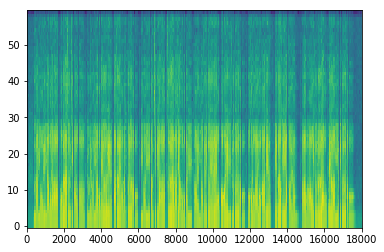

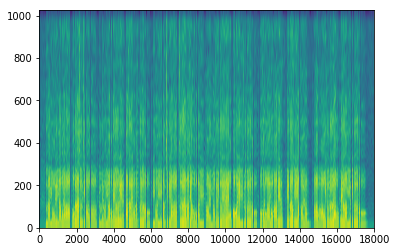

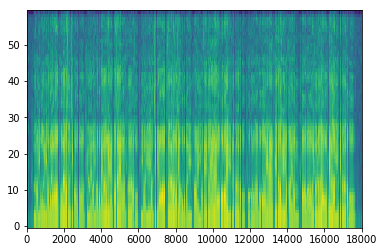

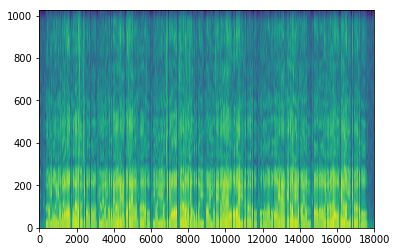

  0%|          | 18/18000 [00:00<01:44, 171.33it/s]

load model snapshots/aperiodic/aper_1649_2019-07-02_11-23-16


100%|██████████| 18000/18000 [01:40<00:00, 179.78it/s]


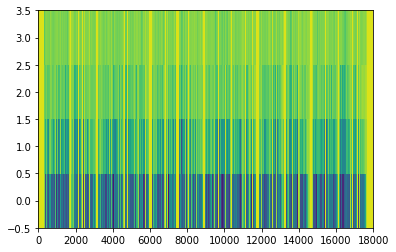

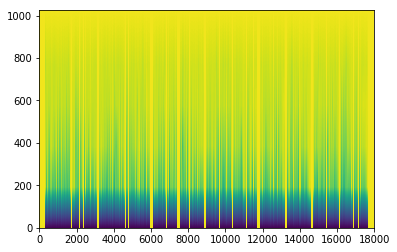

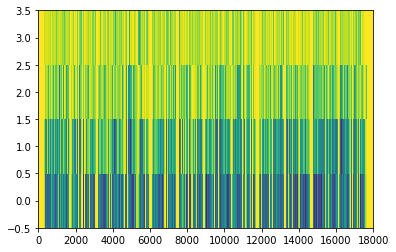

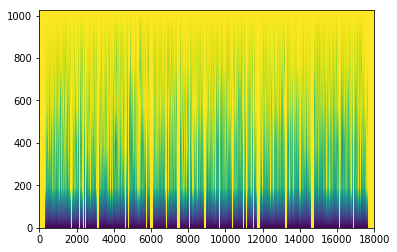

  0%|          | 31/18000 [00:00<00:58, 305.77it/s]

load model snapshots/vuv/vuv_1649_2019-07-02_14-22-29


 15%|█▌        | 2725/18000 [00:08<00:48, 317.82it/s]

In [ ]:
def gen_song(song_name, t, epoch):    
    [sp_min, sp_max, ap_min, ap_max] = np.load('data/timbre_model/min_max_record.npy')
    condi = get_condition(song_name)
    #cat_input = get_ap_cat()
    #fist_input = get_first_input(song_name)
    sp, raw_sp = generate_timbre(0, sp_max, sp_min, condi, None)

    plt.imshow(np.log(np.transpose(sp)), aspect='auto', origin='bottom', interpolation='none')
    plt.show()

    sp1 = load_timbre('data/timbre_model/test/sp/nitech_jp_song070_f001_'+song_name+'_sp.npy', 0, sp_max, sp_min)

    plt.imshow(np.log(np.transpose(sp1)), aspect='auto', origin='bottom', interpolation='none')
    plt.show()
####################################################################################################
    ap, raw_ap = generate_timbre(1, ap_max, ap_min, condi, raw_sp)
    
    plt.imshow(np.log(np.transpose(ap)), aspect='auto', origin='bottom', interpolation='none')
    plt.show()
    
    ap1 = load_timbre('data/timbre_model/test/ap/nitech_jp_song070_f001_'+song_name+'_ap.npy', 1, ap_max, ap_min)
    
    plt.imshow(np.log(np.transpose(ap1)), aspect='auto', origin='bottom', interpolation='none')
    plt.show()

#########################################################################################################
    # vuv_cat = get_vuv_cat()
    gen_cat = torch.cat((raw_ap, raw_sp), 0)
    
    vuv = generate_vuv(condi, gen_cat)
    plt.plot(vuv)
    plt.show()
    
    vuv1 = np.load('data/timbre_model/test/vuv/nitech_jp_song070_f001_'+song_name+'_vuv.npy')
    plt.plot(vuv1)
    plt.show()

    path = 'data/raw/nitech_jp_song070_f001_'+song_name+'.raw'
    _f0, _sp, code_sp, _ap, code_ap = process_wav(path)
    # 合成原始语音
    synthesized = pw.synthesize(_f0, sp, _ap, 32000, pw.default_frame_period)
    # 1.输出原始语音
    sf.write('./data/gen_wav/'+epoch+'epoch_'+t+'_'+song_name+'.wav', synthesized, 32000)

song_name = '040'
t = '6-29_paper_piecewise_logf0'
epoch = '1650'

gen_song(song_name, t, epoch)


In [ ]:
a=torch.rand(2,3).cuda()


In [ ]:
a.cpu()